In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv('data/train_data.csv')

In [41]:
key_columns = ['Gender', 'IsActiveMember', 'Exited', 'Geography', 'NumOfProducts', 'Age']
utils_columns = ['Balance']

In [42]:
df = df[key_columns +utils_columns]
df.head()

,Gender,IsActiveMember,Exited,Geography,NumOfProducts,Age,Balance
0,Male,1.0,0,France,1,28.0,131694.04
1,Male,1.0,0,France,2,34.0,0.00
2,Male,1.0,0,France,2,39.0,0.00
3,Female,0.0,1,Germany,3,56.0,118577.24
4,Female,1.0,0,France,2,33.0,0.00


# Pre-processing

### TrainTest - Nettoyage - Encodage

In [43]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [44]:
trainset['Exited'].value_counts()

Exited
0    90534
1    24329
Name: count, dtype: int64

In [45]:
testset['Exited'].value_counts()

Exited
0    22595
1     6121
Name: count, dtype: int64

### Encodage

In [46]:
def encodage(df):
    encoder = OneHotEncoder(sparse_output=False, drop="first")
    encoded = encoder.fit_transform(df[["Gender"]])   # fit + transform
    cols = encoder.get_feature_names_out(["Gender"])  # noms des colonnes
    encoded_df = pd.DataFrame(encoded, columns=cols, index=df.index)
    # on enlève Gender et on concatène l'encodage
    df = pd.concat([df.drop(columns=["Gender"]), encoded_df], axis=1)
    return df


In [47]:
def feature_engineering(df):
    df['IsGerman'] = (df['Geography'] == 'Germany').astype(int)

    df["NumProductsGroup"] = np.where(df["NumOfProducts"] == 1, 1,
                         np.where(df["NumOfProducts"] == 2, 2, 3))
    
    df['HasBalance'] = (df['Balance'] > 0).astype(int)

    df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[0, 30, 35, 40, 45, 50, 55, 60, 100],
    labels=[1, 2, 3, 4, 5,6, 7, 8]
    )
    return df

In [48]:
def imputation(df):
    df = df.drop(columns=["Balance", "Geography", "NumOfProducts", "Age"])
    return df

In [49]:
def preprocessing(df):
    df = feature_engineering(df)
    df = encodage(df)
    df = imputation(df)
    
    
    X = df.drop('Exited', axis=1)
    y = df['Exited']
    print(y.value_counts())

    return X, y

In [50]:
X_train, y_train = preprocessing(trainset)
X_test, y_test= preprocessing(testset)

Exited
0    90534
1    24329
Name: count, dtype: int64
Exited
0    22595
1     6121
Name: count, dtype: int64


## Modellisation

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [52]:
preprocessor = make_pipeline(
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
    SelectKBest(f_classif, k=10),
)

In [53]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
DecisionTreeC = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
# SVMachine = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNNe = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [54]:
dict_of_models = {'RandomForest' : RandomForest, 
                  'DecisionTreeClassifier' : DecisionTreeC,
                  'AdaBoost' : AdaBoost,
                  'KNN' : KNNe
                  }

## Evaluation

In [55]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [56]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1', train_sizes=np.linspace(0.1 ,1, 10))

    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    

RandomForest
[[21347  1248]
 [ 2745  3376]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     22595
           1       0.73      0.55      0.63      6121

    accuracy                           0.86     28716
   macro avg       0.81      0.75      0.77     28716
weighted avg       0.85      0.86      0.85     28716

DecisionTreeClassifier
[[21349  1246]
 [ 2750  3371]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     22595
           1       0.73      0.55      0.63      6121

    accuracy                           0.86     28716
   macro avg       0.81      0.75      0.77     28716
weighted avg       0.85      0.86      0.85     28716

AdaBoost
[[21419  1176]
 [ 2921  3200]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22595
           1       0.73      0.52      0.61      6121

    accuracy                           0.86 

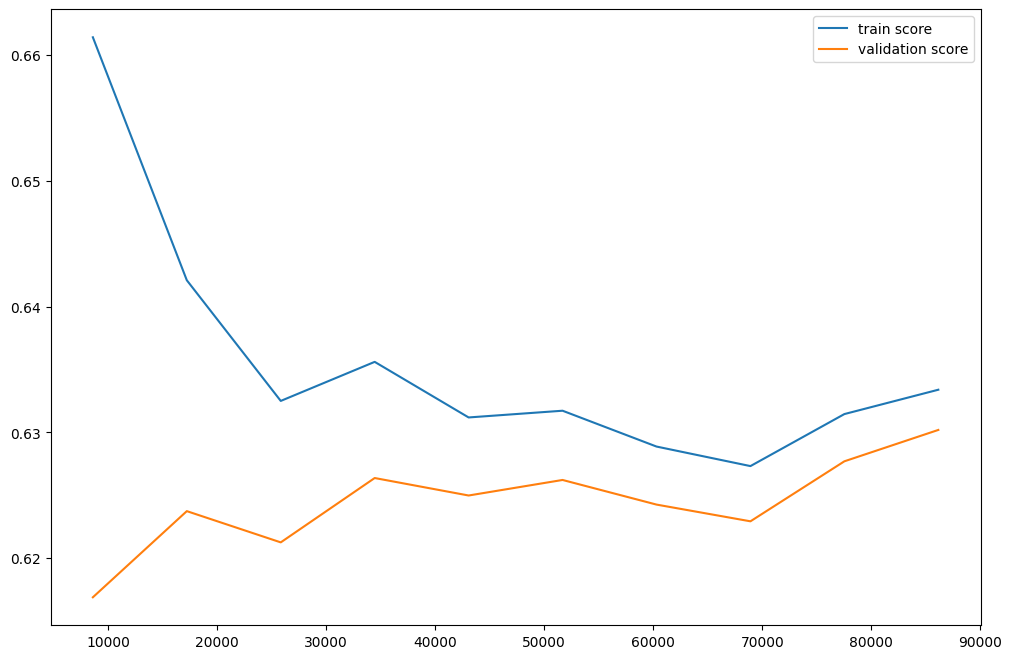

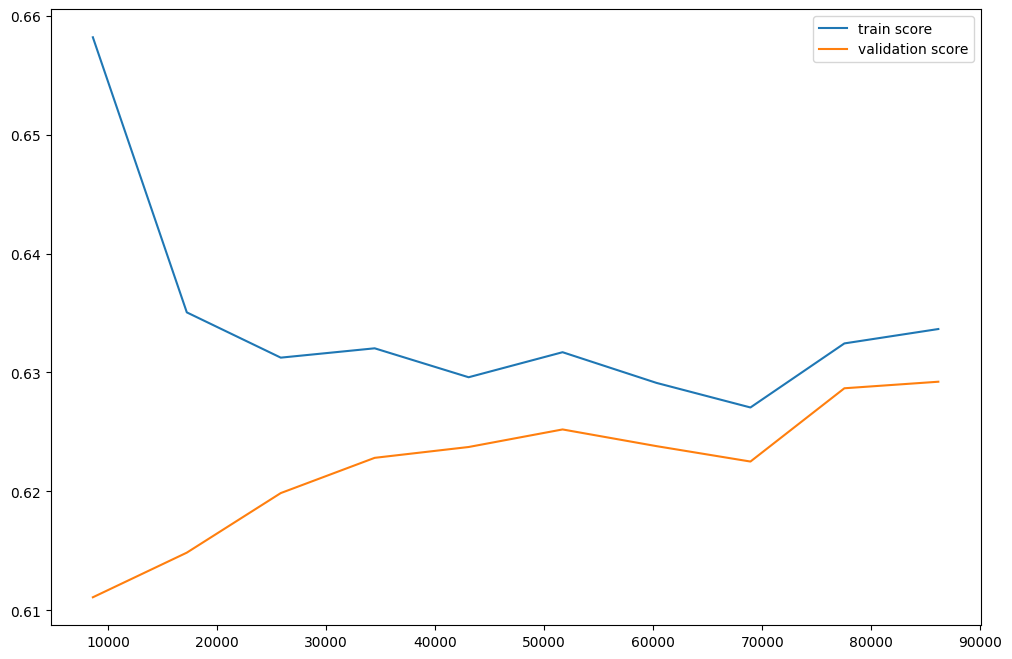

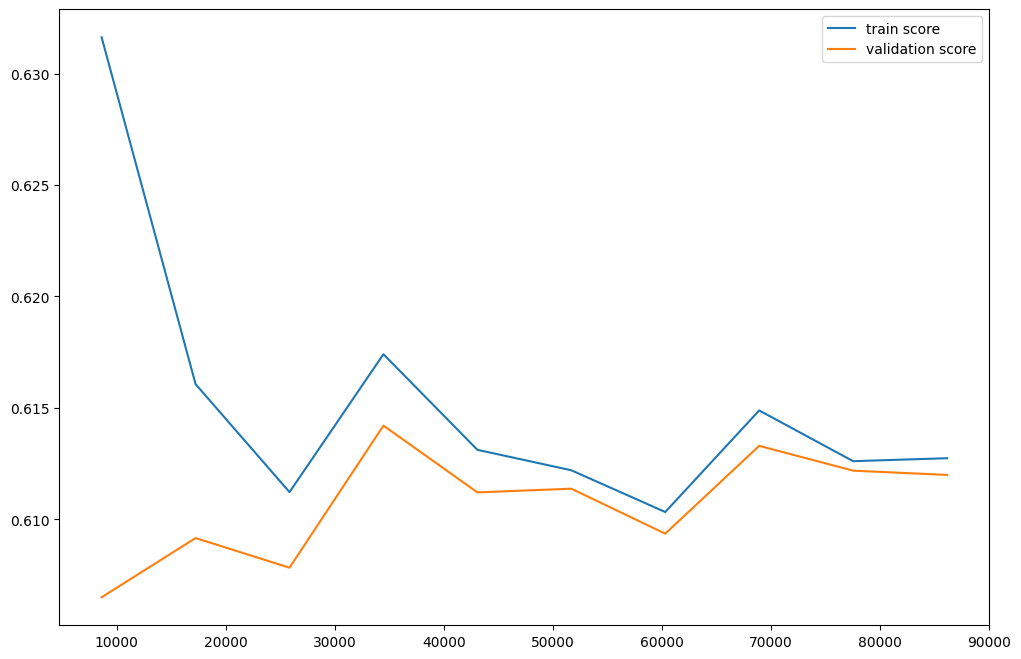

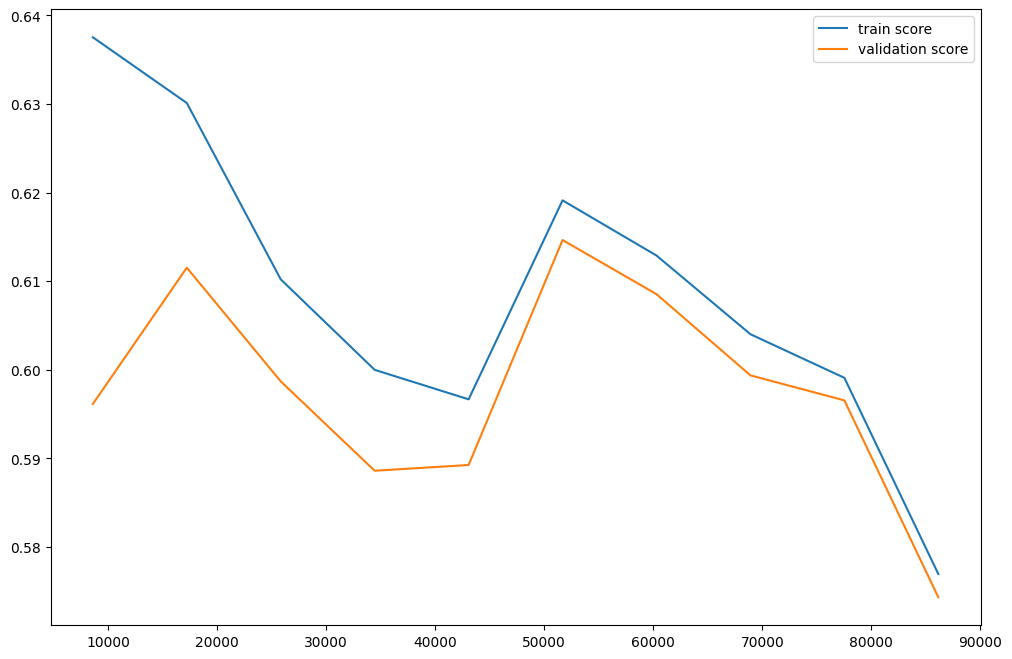

In [57]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

## OPTIMISATION


In [76]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [90]:
hyper_params = {'randomforestclassifier__n_estimators' : [90, 95, 100, 105, 110],
                'randomforestclassifier__max_depth' : [None, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
                'randomforestclassifier__min_samples_split' : [2, 3],
                'randomforestclassifier__min_samples_leaf' : [2, 3],
                'randomforestclassifier__max_features' : ["sqrt", "log2", None], 
                'randomforestclassifier__class_weight': [None, "balanced"],
                'pipeline__selectkbest__k':range(4, 21),
                'pipeline__polynomialfeatures__degree': [2, 3, 4]
                }

In [91]:
grid = RandomizedSearchCV(RandomForest, hyper_params, scoring='f1', cv=4 ,n_jobs=12, n_iter=500)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

{'randomforestclassifier__n_estimators': 105, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': None, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__class_weight': 'balanced', 'pipeline__selectkbest__k': 18, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     22595
           1       0.54      0.77      0.64      6121

    accuracy                           0.81     28716
   macro avg       0.74      0.80      0.75     28716
weighted avg       0.85      0.81      0.82     28716



[[18552  4043]
 [ 1375  4746]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     22595
           1       0.54      0.78      0.64      6121

    accuracy                           0.81     28716
   macro avg       0.74      0.80      0.75     28716
weighted avg       0.85      0.81      0.82     28716



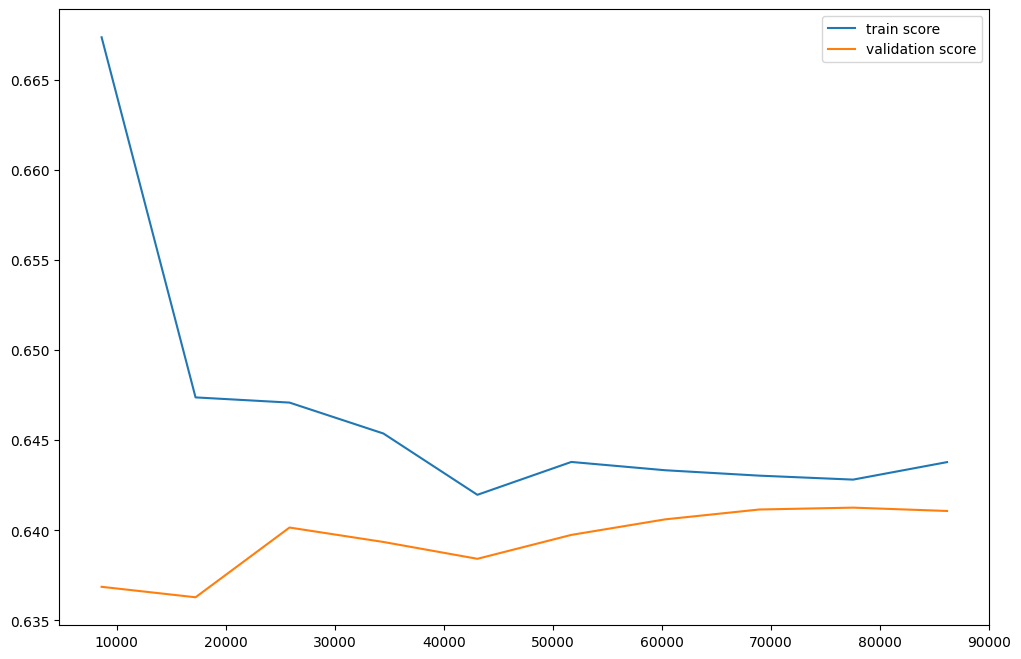

In [78]:
evaluation(grid.best_estimator_)

### Precision Recall Curve

In [92]:
from sklearn.metrics import precision_recall_curve

In [96]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1])

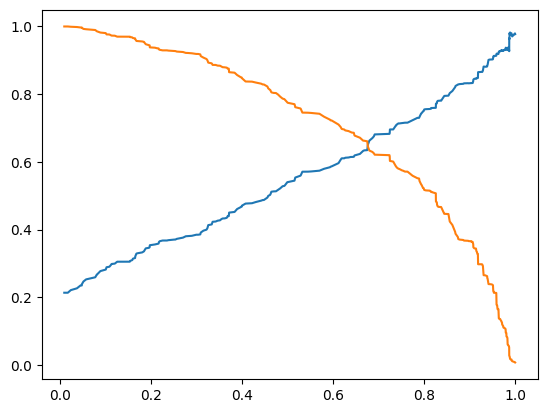

In [100]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend
plt.show()

In [104]:
def model_final(model, X, threshold=0.5):
    proba = model.predict_proba(X)[:, 1]  # proba classe positive
    return (proba > threshold).astype(int)

In [105]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=0.7)

In [106]:
f1_score(y_test, y_pred)

0.6496531643401559

## Prediction kaggle

In [128]:
df_kaggle = pd.read_csv('data/test_data.csv')

In [129]:
# 1) garde l'ID AVANT le preprocessing
id_col = "ID"          # ou "CustomerId" selon ton fichier Kaggle
test_ids = df_kaggle[id_col].copy()

In [130]:
key_columns_kaglle = ['Gender', 'IsActiveMember', 'Geography', 'NumOfProducts', 'Age']
utils_columns_kaggle = ['Balance']

In [131]:
df_kaggle = df_kaggle[key_columns_kaglle + utils_columns_kaggle]

In [133]:
def preprocessing_kaggle(df):
    df = feature_engineering(df)
    df = encodage(df)
    df = imputation(df)
    
    
    X = df

    return X

In [134]:
X_kaggle = preprocessing_kaggle(df_kaggle)

In [135]:
y_pred_kaggle = model_final(grid.best_estimator_, X_kaggle, threshold=0.7)

In [136]:
results = pd.DataFrame(
    {
        id_col: test_ids,
        "Exited": y_pred_kaggle
    }
)
#results.set_index("ID")

In [137]:
results.to_csv("predictions.csv", index=False)